In [1]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join

set1_dir = "../images/set1/"
set2_dir = "../images/set2/"
set3_dir = "../images/set3/"

set1_images = [np.array(cv2.imread(set1_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set1_dir))]
set2 = [np.array(img.imread(set2_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set2_dir))]
set3 = [np.array(img.imread(set3_dir + f, cv2.IMREAD_GRAYSCALE)) for f in sorted(listdir(set3_dir))]


In [2]:

rows = set1_images[0].shape

In [3]:
def imregionalmax(image, kernel=None):
    """Find the regional max of the image. An approximation of MATLAB's
    imregionalmax function. Result only differs when surrounding pixels
    have the same value as the center.

    Parameters:
    - image: the input image
    - kernel: the size of the neiborhood region, default is 3x3, i.e.
              neighboring 8 pixels.
    Returns:
    - a bitmask image, where '1' indicates local maxima.
    Author:
    - Yu Fang
    References:
    - https://github.com/bhardwajvijay/Utils/blob/master/utils.cpp
    - https://stackoverflow.com/questions/5550290/find-local-maxima-in-grayscale-image-using-opencv
    """
    # dialate the image so that small values are replaced by local max
    local_max = cv2.dilate(image, kernel)
    # non-local max pixels (excluding pixel w/ constant 3x3 neighborhood)
    # will be replaced by local max, so the values will increase. remove them.
    # so the result is either local max or constant neighborhood.
    max_mask = image >= local_max
    # erode the image so that high values are replaced by local min
    local_min = cv2.erode(image, kernel)
    # only local min pixels and pixels w/ constant 3x3 neighborhood
    # will stay the same, otherwise pixels will be replaced by the local
    # min and become smaller. We only take non-local min, non-constant values.
    min_mask = image > local_min
    # boolean logic hack
    #   (local max || constant) && (!local min && !constant)
    # = local max && !local min && !constant
    # = local max && !constant
    return (max_mask & min_mask).astype(np.uint8)

In [4]:
def est_homography(src, dest):
    """ Compute the homography matrix from (x_src, y_src) to (x_dest, y_dest).
    Parameters:
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    - dest: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
            so the matrix has dimension Nx2 (N>=4).
    Returns:
    - the homography matrix such that H @ [x_src, y_src, 1].T = [x_dest, y_dest, 1].T
    Author:
    - Yu Fang
    """
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    # take the right singular vector x corresponding to the least singular value
    # s.t. ||Ax - 0||^2 is minimized
    return V.T[:, 8].reshape(3, 3)

In [5]:
def apply_homography(H, src):
    """ Apply the homography H to src
    Parameters:
    - H: the 3x3 homography matrix
    - src: (x,y) coordinates of N source pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Returns:
    - src: (x,y) coordinates of N destination pixels, where coordinates are row vectors,
           so the matrix has dimension Nx2 (N>=4).
    Author:
    - Yu Fang
    """
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

In [6]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    """A wrapper around OpenCV's drawMatches.
    
    Parameters:
    - image1: the first image
    - kp1: *matrix indices* of the keypoints from image 1
           (Nx2 numpy array, where N is the number of keypoints)
    - image2: the second image
    - kp2: *matrix indices* of the keypoints from image 2 
           (Nx2 numpy array, where N is the number of keypoints)
    - idx_pairs: pairs of matching indices, e.g. if kp1[3] 
                 matches kp2[5], then idx_pairs=[[3,5],...]
                 (Kx2 numpy array, where K is the number of matches)
    Returns:
    - an image showing matching points
    Author:
    - Yu Fang
    """
    # note that the coordinates are reversed because the difference
    # between matrix indexing & coordinates.
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [7]:

print(f"1.jpg:\n{set1_images[0]}")
print(f"regionmal max:\n{imregionalmax(set1_images[0])}")

1.jpg:
[[255 255 255 ... 134 196 192]
 [255 255 255 ... 132 173 202]
 [255 255 255 ... 129 187 201]
 ...
 [116 113 112 ...  16  15  26]
 [115 111 112 ...  23  22  24]
 [110 106 107 ...  29  26  28]]
regionmal max:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [8]:
# homography example (remove this block in the final submission)
src = np.array([
    [0, 0],
    [3, 0],
    [0, 2],
    [3, 2]
])
dest = np.array([
    [10, 10],
    [13, 10],
    [12, 12],
    [15, 12]
])

H = est_homography(src, dest)
print(f"H:\n{H}")
dest2 = apply_homography(H, src)
print(f"recover dest:\n{dest2}")

H:
[[-7.00140042e-02 -7.00140042e-02 -7.00140042e-01]
 [ 4.33338378e-15 -7.00140042e-02 -7.00140042e-01]
 [ 4.53873313e-16  8.07299370e-17 -7.00140042e-02]]
recover dest:
[[10. 10.]
 [13. 10.]
 [12. 12.]
 [15. 12.]]


In [81]:
def amns(C, n_best):
    '''
    Adaptive Non-Maximal Suppression
    '''
    # Obtain local maxima of C
    local_maxima = imregionalmax(C)
    # Find the (x,y) coordinates for the local maxima
    coords = np.array([[row, col] for row in range(0, local_maxima.shape[0]) for col in range(0, local_maxima.shape[1]) if local_maxima[row, col] == 1])
    r = {}
    for c in coords:
        r[tuple(c)] = np.inf
    # For each local maxima, check the corner response relative to every other corner 
    c_robust = 0.9
    C_scaled = c_robust * C
    for c in coords:
        # Obtain the list of suppressing points
        suppressing_points = np.array(np.where(C[c[0], c[1]] < C_scaled)).T
        
        # Calculate distances from current points to supressing points
        distances = np.sum((suppressing_points - np.array([c[0], c[1]])) ** 2, axis=1)

        # Update the minimum distance for the current point
        r[tuple(c)] = np.sort(distances)[0] if len(distances) > 0 else r[tuple(c)]

    return np.array([c[0] for c in sorted(r.items(), key=lambda t: t[1], reverse=True)][:n_best])

In [73]:
set1_feature_points = []
strongest_corners = 500
block_size = 4
k_size = 3
k = 0.04
for im in set1_images:
    set1_feature_points.append(amns(cv2.cornerHarris(im, block_size, k_size, k), strongest_corners))

set1_feature_points

[array([[222,   3],
        [222,   5],
        [222,  12],
        [222,  14],
        [222,  16],
        [222,  21],
        [194, 503],
        [416, 369],
        [418, 281],
        [449,  32],
        [297, 394],
        [151, 363],
        [416, 426],
        [299, 178],
        [199, 150],
        [288, 576],
        [298, 231],
        [ 73, 142],
        [295, 503],
        [446, 594],
        [ 53, 361],
        [295, 475],
        [ 33, 465],
        [152, 288],
        [ 62, 554],
        [292,  49],
        [ 54, 289],
        [ 58, 555],
        [346,   7],
        [178, 570],
        [166, 430],
        [  7, 191],
        [  8, 191],
        [  9, 191],
        [105, 478],
        [119,  15],
        [346, 586],
        [120,  15],
        [121,  15],
        [297, 448],
        [299, 285],
        [417, 228],
        [392,  48],
        [363, 493],
        [ 79, 228],
        [135, 137],
        [ 91, 557],
        [215, 367],
        [  6, 385],
        [329, 117],


In [74]:
# Update strongest without rerunning
# regular_corners = False
# backup_corners = []

# if not regular_corners:
#     num_corners = 10
#     backup_corners = set1_amns
#     for c in set1_amns:
#         backup_corners.append(c[:num_corners])

# backup_corners

<function matplotlib.pyplot.show(close=None, block=None)>

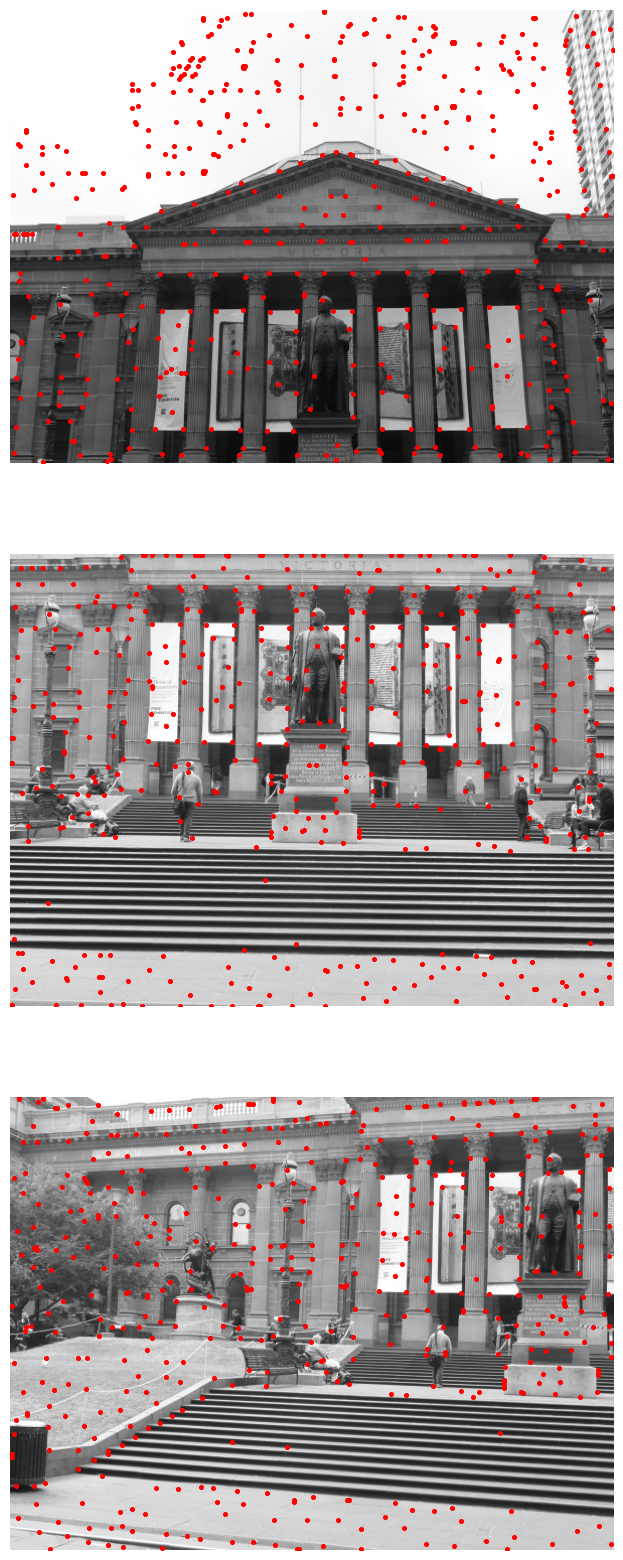

In [75]:
image_plot = []

fig = plt.figure(figsize=(50,20))
for i in range(len(set1_images)):
    fig.add_subplot(3,1,i + 1)
    plt.imshow(cv2.cvtColor(set1_images[i], cv2.COLOR_BGR2RGB))
    plt.scatter(set1_feature_points[i][:, 1], set1_feature_points[i][:, 0], c='r', s=7)
    plt.axis("off")
plt.show

(450, 600)

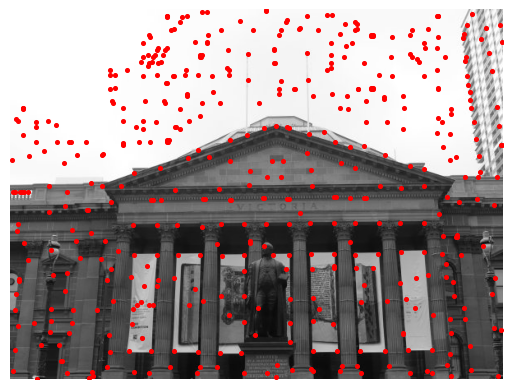

In [76]:
plt.imshow(cv2.cvtColor(set1_images[0], cv2.COLOR_BGR2RGB))
# axes[0].set_title('Image 1 with Corresponding Points')
# if regular_corners:
plt.scatter(set1_feature_points[0][:, 1], set1_feature_points[0][:, 0], c='r', s=7)
# else:
#     print("BACKUP")
#     plt.scatter(backup_corners[0][:, 1], backup_corners[0][:, 0], c='r', s=7)
plt.axis("off")
set1_images[0].shape

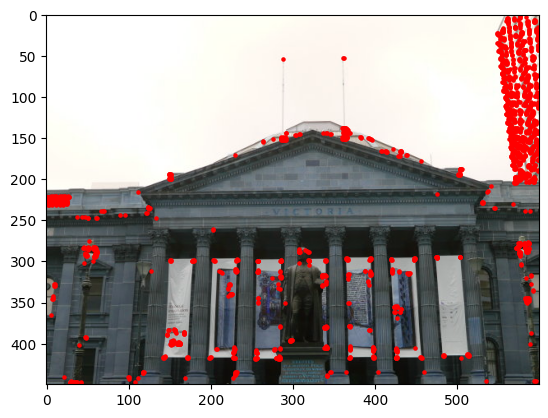

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.3759194e-05, -5.2392613e-03, -2.2025795e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.3759194e-05, -5.2392613e-03, -2.2025795e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.3077591e-05, -4.7427351e-03,  1.5036296e-04],
       ...,
       [-1.5334259e-03, -1.5334259e-03, -1.5233723e-03, ...,
        -7.9563819e-03, -9.3093412e-03, -9.6248155e-03],
       [-9.6331508e-04, -9.6331508e-04, -9.3463378e-04, ...,
        -3.8247625e-03, -4.0774620e-03, -4.1034026e-03],
       [-6.6432358e-06, -6.6432358e-06, -3.8600701e-06, ...,
         1.7153687e-05, -8.7928447e-06, -1.5068796e-05]], dtype=float32)

In [77]:

corners = cv2.cornerHarris(set1_images[0],2,5,0.04)
image = cv2.imread("../images/set1/1.jpg")
image[corners>0.01*corners.max()]=[0,0,255]

coords = np.array([[row, col] for row in range(0, image.shape[0]) for col in range(0, image.shape[1]) if image[row, col][0] == 0 and image[row, col][1] == 0 and image[row, col][2] == 255])
plt.scatter(coords[:,1], coords[:,0], c='r',s=5)
plt.imshow(image)
plt.show()
corners

In [78]:
observation = np.array([111.0, 188.0])
codes = np.array([[102.0, 203.0],
               [132.0, 193.0],
               [45.0, 155.0],
               [57.0, 173.0]])
diff = codes - observation    # the broadcast happens here
dist = np.sqrt(np.sum(diff**2,axis=-1))
np.argmin(dist)

0

In [79]:
dist

array([17.49285568, 21.58703314, 73.79024326, 56.04462508])

In [80]:
points = [(26406, -6869), (28259, -892)]
# make test array my repeating the 28-element points list 1M times
np_points = np.array(points*1000000, dtype='int32')
# use two different slices (offset by 1) from resulting array;
# execution of next line takes ~1 second
dists = np.sqrt(np.sum((np_points[0:-2] - np_points[1:-1])**2, axis=1))
dists.shape
np_points.shape

(2000000, 2)